In [1]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join, vstack
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import ascii

from scipy.interpolate import interp1d
from scipy.stats import binned_statistic

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from pyia import GaiaData

### Load APOGEE data

(Internal APOGEE ~DR15 reduction and cross-match to Gaia DR2)

In [81]:
xmatch = Table.read('/Users/adrian/data/APOGEE_DR15beta/gaiadr2_allStar-t9-l31c-58158.fits')
xmatch.rename_column('apstar_id', 'APSTAR_ID')

In [82]:
apogee = Table.read('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158.fits')

In [83]:
apogee_gaia = join(apogee, xmatch, keys='APSTAR_ID')
ndim_cols = [x for x in apogee_gaia.columns if apogee_gaia[x].ndim == 1]
apogee_gaia = apogee_gaia[ndim_cols]
apogee_gaia = apogee_gaia[apogee_gaia['parallax'] < 1.]

g = GaiaData(apogee_gaia)
len(g)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


231808

# Predict Orphan properties 

Taken from Hendel et al. 2018 - with PM prior

In [4]:
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc)

In [32]:
pot = gp.CCompositePotential()

pot['disk'] = gp.MiyamotoNagaiPotential(m=1e11*u.Msun, a=6.5, b=0.26, units=galactic)

pot['sph'] = gp.HernquistPotential(m=3.4e10*u.Msun, c=0.7, units=galactic)

vh = 128. * np.sqrt(2) * u.km/u.s
pot['halo'] = gp.LogarithmicPotential(v_c=vh, r_h=13.01, q1=1, q2=1, q3=1, units=galactic)

pot.mass_enclosed([60, 0, 0.])

<Quantity [  5.67948815e+11] solMass>

In [34]:
c0 = coord.SkyCoord(l=199.7796*u.deg,
                    b=52.46*u.deg,
                    distance=coord.Distance(distmod=17.66),
                    pm_l_cosb=0.244 * u.mas/u.yr,
                    pm_b=-0.715 * u.mas/u.yr,
                    radial_velocity=176.2 * u.km/u.s,
                    frame='galactic')

In [35]:
w0 = gd.PhaseSpacePosition(c0.transform_to(gc_frame).cartesian)

In [120]:
_orbit = pot.integrate_orbit(w0, dt=-1*u.Myr, n_steps=500)
orbit = pot.integrate_orbit(_orbit[-1], dt=1*u.Myr, n_steps=1000)

orbit_icrs = orbit.to_coord_frame(coord.ICRS, galactocentric_frame=gc_frame)
orbit_c = orbit.to_coord_frame(gc.Orphan, galactocentric_frame=gc_frame)

In [1]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax = axes[0]
ax.scatter(orbit_icrs.ra.degree, orbit_icrs.dec.degree, c=orbit.t.value)
ax.set_xlim(240, 90)
ax.set_ylim(-80, 80)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

ax = axes[1]
ax.scatter(orbit_c.phi1.wrap_at(180*u.deg).degree, orbit_c.phi2.degree, c=orbit.t.value)
ax.set_xlim(-90, 90)
ax.set_ylim(-10, 10)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')

NameError: name 'plt' is not defined

### Sky position mask

In [216]:
phi1_to_phi2 = interp1d(orbit_c.phi1.wrap_at(180*u.deg).degree, 
                        orbit_c.phi2.degree, bounds_error=False)

phi1_to_rv = interp1d(orbit_c.phi1.wrap_at(180*u.deg).degree, 
                      orbit_c.radial_velocity.to(u.km/u.s).value,
                      bounds_error=False)

grid = np.linspace(-90, 90, 128)
grid_phi2 = phi1_to_phi2(grid)

grid_phi1 = np.concatenate((grid, grid[::-1]))
grid_phi2 = np.concatenate((grid_phi2 + 1., grid_phi2[::-1] - 1.))

phi_poly = np.vstack((grid_phi1, grid_phi2)).T
phi_path = mpl.patches.Path(phi_poly)

### Proper motion mask

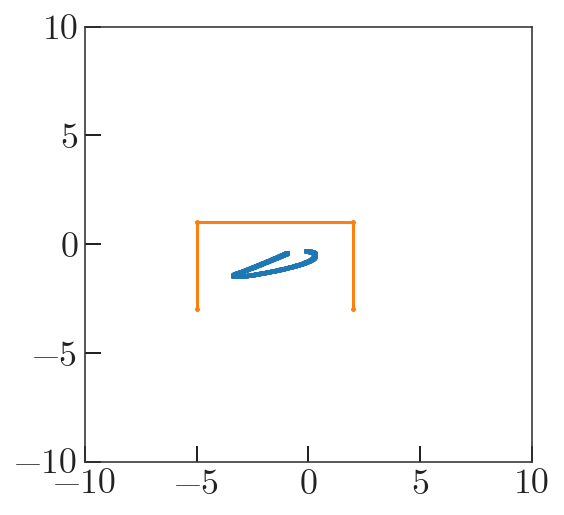

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(orbit_c.pm_phi1_cosphi2, orbit_c.pm_phi2)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

pm_poly = np.array([[-5, -3],
                    [-5, 1],
                    [2, 1],
                    [2, -3]])
ax.plot(pm_poly[:,0], pm_poly[:,1])

pm_path = mpl.patches.Path(pm_poly)

---

# APOGEE

In [218]:
c = g.get_skycoord(distance=False,
                   radial_velocity=np.array(g.VHELIO_AVG)*u.km/u.s)
c = c.transform_to(gc.Orphan)

phi1 = c.phi1.wrap_at(180*u.deg)
phi2 = c.phi2

pm1 = c.pm_phi1_cosphi2.to(u.mas/u.yr)
pm2 = c.pm_phi2.to(u.mas/u.yr)

In [219]:
phi_mask = phi_path.contains_points(np.vstack((phi1, phi2)).T)
pm_mask = pm_path.contains_points(np.vstack((pm1, pm2)).T)

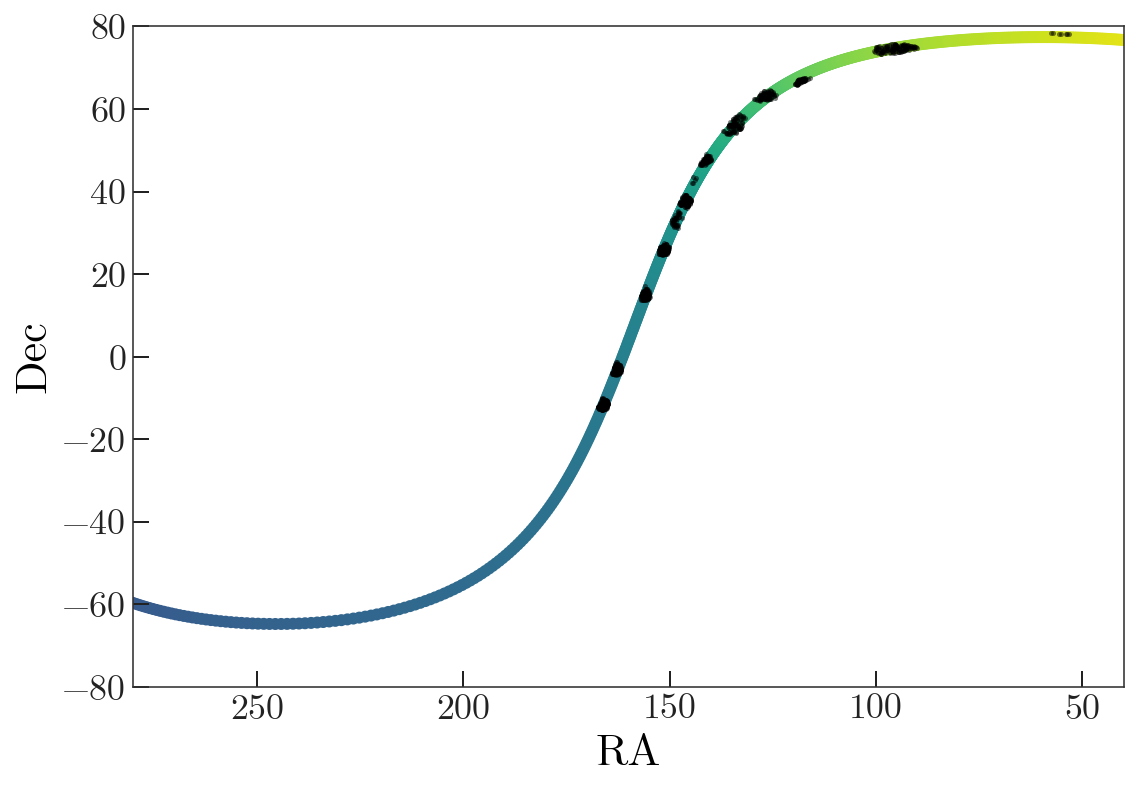

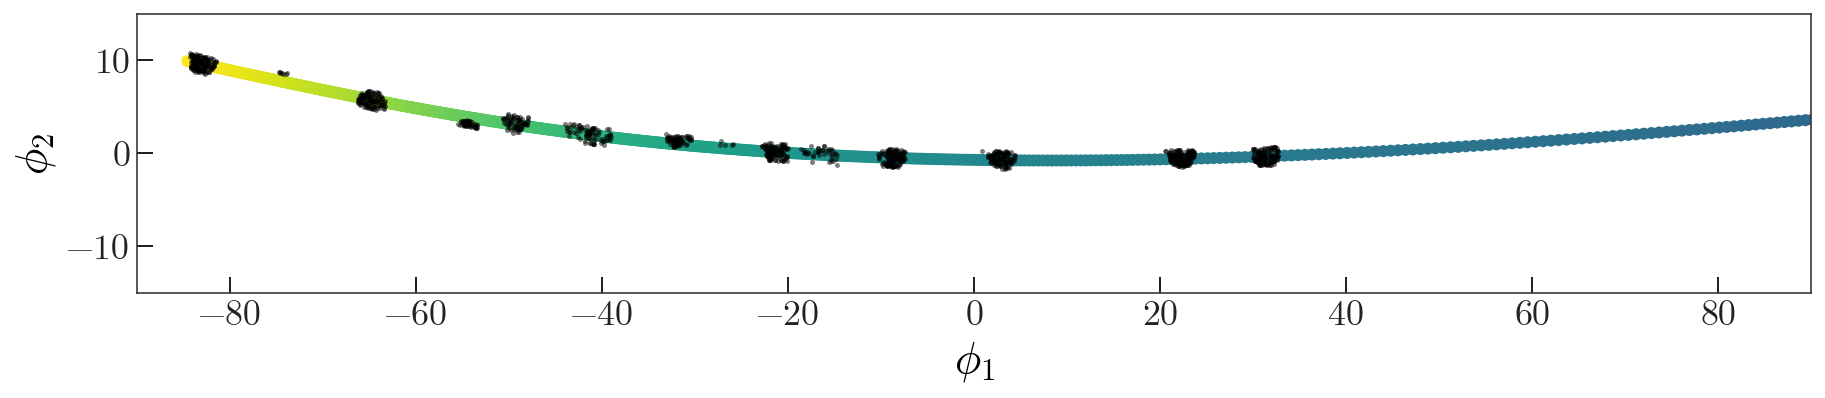

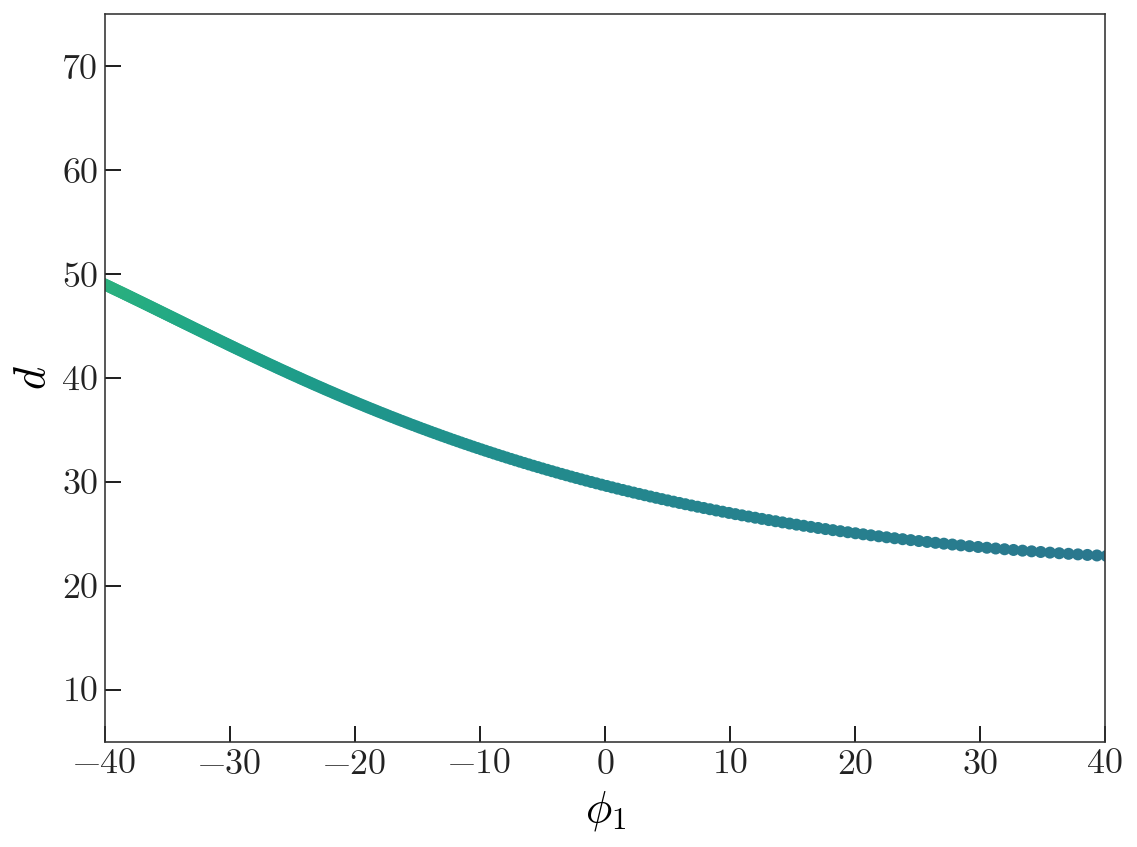

In [242]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(g.ra[phi_mask], g.dec[phi_mask], 
        marker='.', color='k', ls='none', alpha=0.5)

ax.scatter(orbit_icrs.ra.degree, orbit_icrs.dec.degree, c=orbit.t.value)

ax.set_xlim(280, 40)
ax.set_ylim(-80, 80)
ax.set_aspect('equal')

ax.set_xlabel(r'RA')
ax.set_ylabel(r'Dec')

fig.tight_layout()
fig.savefig('../plots/orphan/radec.png', dpi=250)

# ---

fig, ax = plt.subplots(1, 1, figsize=(15, 3), sharex=True)

ax.plot(phi1[phi_mask], phi2[phi_mask], 
        marker='.', color='k', ls='none', alpha=0.5)

ax.scatter(orbit_c.phi1.wrap_at(180*u.deg).degree, 
           orbit_c.phi2.degree, c=orbit.t.value)

ax.set_xlim(-90, 90)
ax.set_ylim(-15, 15)
ax.set_aspect('equal')

ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')

# ---

fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

ax.scatter(orbit_c.phi1.wrap_at(180*u.deg).degree, 
           orbit_c.distance.value, c=orbit.t.value)

ax.set_xlim(-40, 40)
ax.set_ylim(5, 75)

ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$d$')

fig.tight_layout()
# fig.savefig('../plots/orphan/phi12.png', dpi=250)

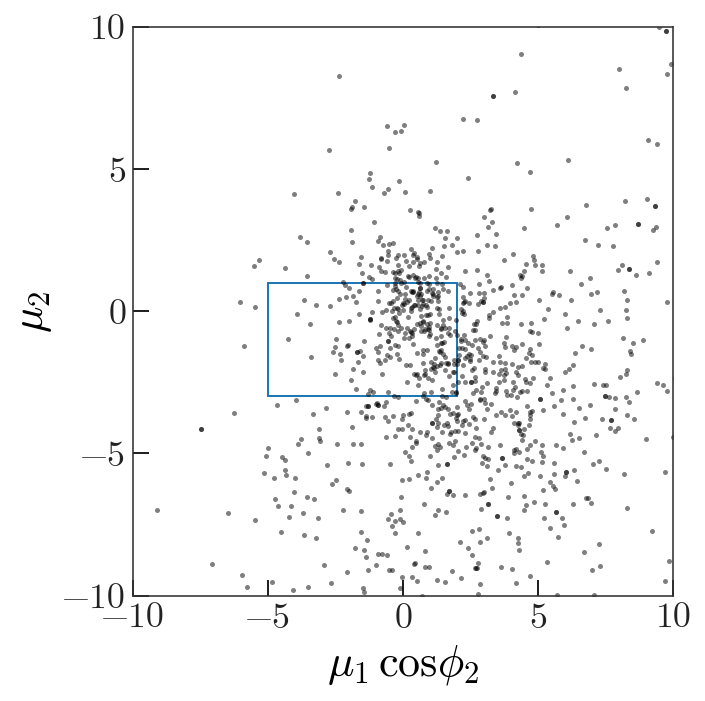

In [221]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(pm1[phi_mask], pm2[phi_mask],  
        marker='.', ls='none', alpha=0.5, color='k')

ax.add_patch(mpl.patches.Polygon(pm_poly, 
                                 facecolor='none', 
                                 edgecolor='tab:blue'))

# ax.scatter(orbit_c.pm_phi1_cosphi2, orbit_c.pm_phi2,
#            zorder=-100, c=orbit.t)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.set_xlabel(r'$\mu_1 \, \cos\phi_2$')
ax.set_ylabel(r'$\mu_2$')

fig.tight_layout()

fig.savefig('../plots/orphan/pm.png', dpi=250)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


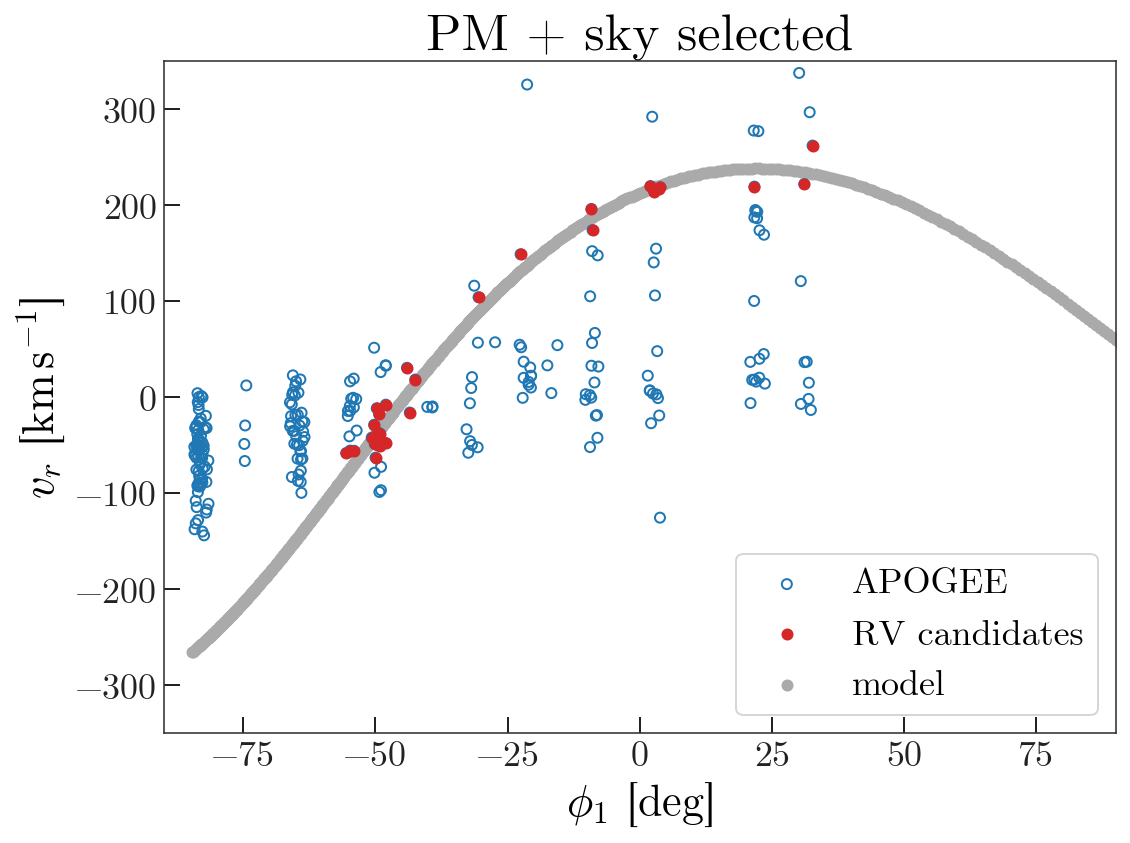

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

rv = g.VHELIO_AVG
drv = np.abs(phi1_to_rv(phi1.value) - rv)
rv_mask = drv < 30.

ax.scatter(phi1[phi_mask & pm_mask], rv[phi_mask & pm_mask], 
           marker='o', color='tab:blue', linewidth=1, facecolor='none',
           alpha=1, s=25, label='APOGEE')

ax.scatter(phi1[phi_mask & pm_mask & rv_mask],
           rv[phi_mask & pm_mask & rv_mask], 
           color='tab:red', label='RV candidates')

ax.scatter(orbit_c.phi1.wrap_at(180*u.deg),
           orbit_c.radial_velocity.to(u.km/u.s), 
           zorder=-100, color='#aaaaaa',
           label='model')

ax.set_xlim(-90, 90)
ax.set_ylim(-350, 350)

ax.set_xlabel(r'$\phi_1$ [deg]')

ax.legend(loc='best', fontsize=18)
ax.set_ylabel(r'$v_r$ [{0:latex_inline}]'.format(u.km/u.s))
ax.set_title('PM + sky selected')
fig.tight_layout()

fig.savefig('../plots/orphan/rv.png', dpi=250)

In [223]:
(phi_mask & pm_mask & rv_mask).sum()

31

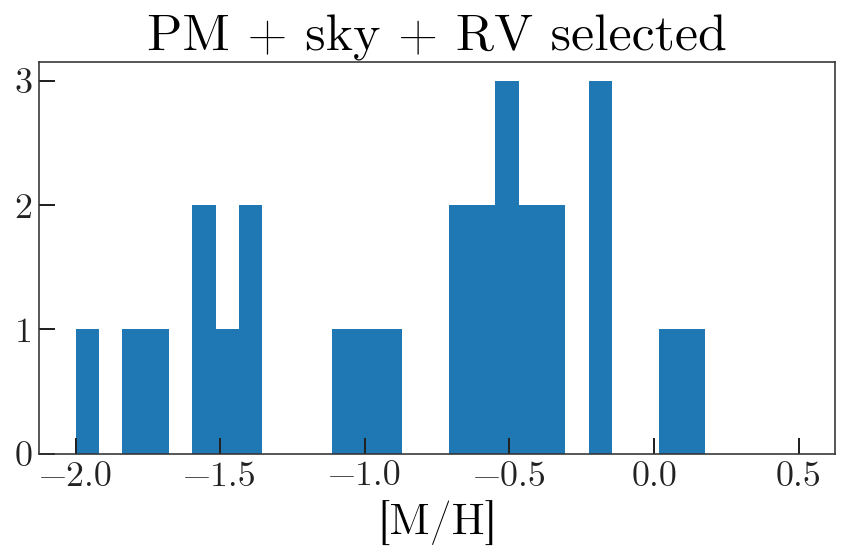

In [224]:
plt.hist(g.M_H[phi_mask & pm_mask & rv_mask], 
         bins=np.linspace(-2, 0.5, 32));
plt.xlabel('[M/H]')
plt.title('PM + sky + RV selected')
plt.tight_layout()
plt.savefig('../plots/orphan/m_h.png', dpi=250)

In [225]:
# chem_mask = ((g.M_H < -1.2) & (g.M_H > -2.1) & 
#              (g.CA_FE < 0.5) & (g.CA_FE > -0.1) &
#              (g.MG_FE > -0.2) & (g.MG_FE < 0.5))
feh_mask = (g.M_H < -1.2) & (g.M_H > -2.1)
chem_mask = ((g.CA_FE < 0.5) & (g.CA_FE > -0.1) &
             (g.MG_FE > -0.2) & (g.MG_FE < 0.5))

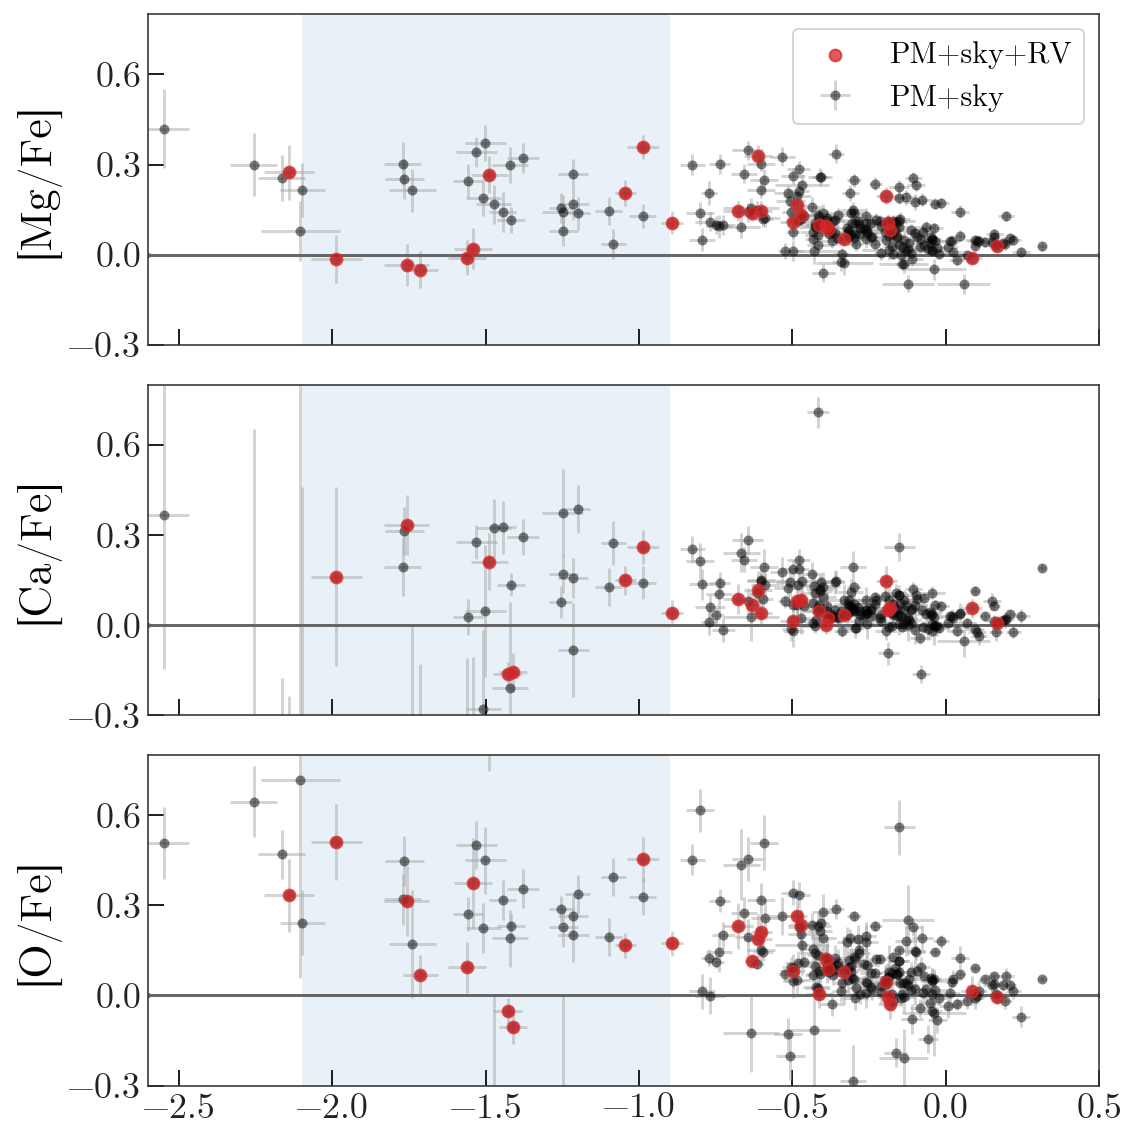

In [226]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8), 
                         sharex=True, sharey=True)

for ax, name, label in zip(axes, ['MG_FE', 'CA_FE', 'O_FE'], 
                           ['[Mg/Fe]', '[Ca/Fe]', '[O/Fe]']):
    ax.errorbar(g.M_H[phi_mask & pm_mask], 
                getattr(g[phi_mask & pm_mask], name), 
                xerr=g.M_H_ERR[phi_mask & pm_mask], 
                yerr=getattr(g[phi_mask & pm_mask], name + '_ERR'), 
                marker='o', ls='none', color='k', ecolor='#aaaaaa', alpha=0.5,
                label='PM+sky')

    ax.scatter(g.M_H[phi_mask & pm_mask & rv_mask], 
               getattr(g[phi_mask & pm_mask & rv_mask], name), 
               marker='o', color='tab:red', alpha=0.75, zorder=100, s=35, 
               label='PM+sky+RV')

    ax.axvspan(-2.1, -0.9, lw=0, 
               zorder=-100, color='tab:blue', alpha=0.1)

    ax.axhline(0)
    ax.set_ylabel(label)
    
axes[0].legend(fontsize=15)

ax.set_xlim(-2.6, 0.5)
ax.set_ylim(-0.3, 0.8)
ax.yaxis.set_ticks([-0.3, 0, 0.3, 0.6])

fig.tight_layout()

fig.savefig('../plots/orphan/alpha.png', dpi=250)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


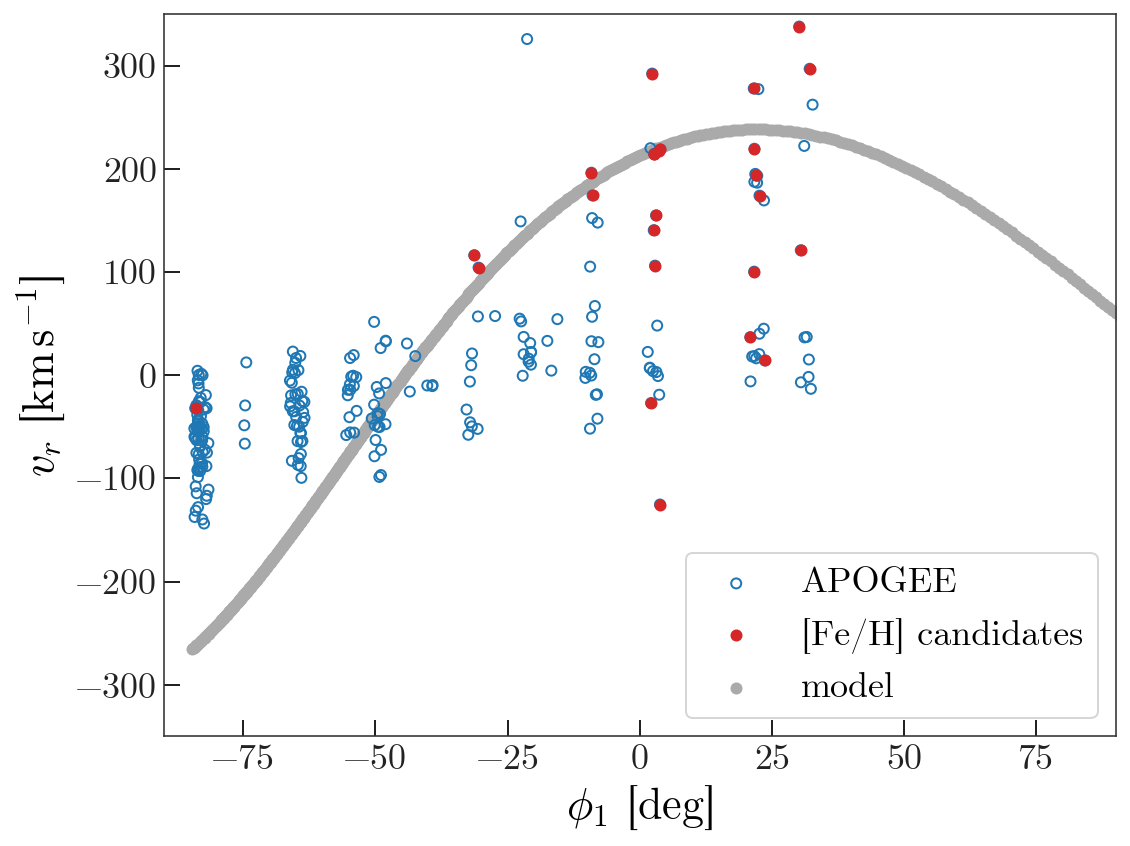

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

rv = g.VHELIO_AVG
drv = np.abs(phi1_to_rv(phi1.value) - rv)
rv_mask = drv < 30.

ax.scatter(phi1[phi_mask & pm_mask], rv[phi_mask & pm_mask], 
           marker='o', color='tab:blue', linewidth=1, facecolor='none',
           alpha=1, s=25, label='APOGEE')

ax.scatter(phi1[phi_mask & pm_mask & feh_mask],
           rv[phi_mask & pm_mask & feh_mask], 
           color='tab:red', label='[Fe/H] candidates')

ax.scatter(orbit_c.phi1.wrap_at(180*u.deg),
           orbit_c.radial_velocity.to(u.km/u.s), 
           zorder=-100, color='#aaaaaa',
           label='model')

ax.set_xlim(-90, 90)
ax.set_ylim(-350, 350)

ax.set_xlabel(r'$\phi_1$ [deg]')

ax.legend(loc='best', fontsize=18)
ax.set_ylabel(r'$v_r$ [{0:latex_inline}]'.format(u.km/u.s))
fig.tight_layout()

In [228]:
(phi_mask & pm_mask & rv_mask & feh_mask).sum()

8

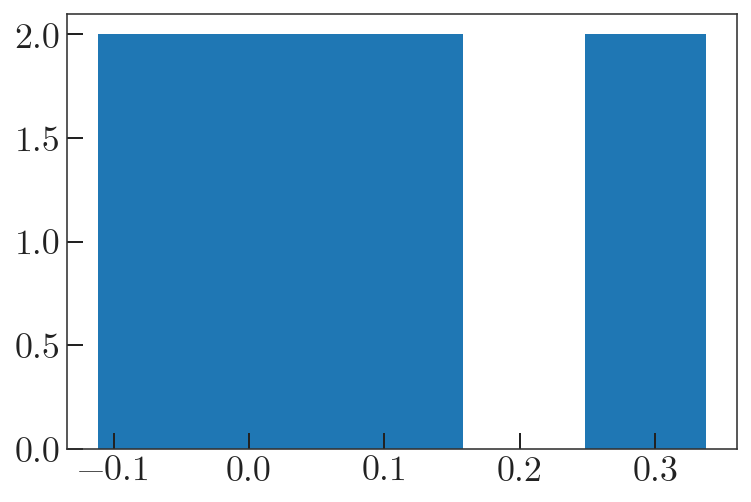

In [229]:
plt.hist(g[phi_mask & pm_mask & rv_mask & feh_mask].ALPHA_M, bins='auto');

In [245]:
DM = coord.Distance(30*u.kpc).distmod.value
DM

17.385606273598313

In [255]:
isos = []

iso = ascii.read('../isochrones/8Gyr_FeH-1.6_2MASS.cmd', header_start=12)
iso = iso[iso['phase'] < 4]
isos.append(iso)

iso = ascii.read('../isochrones/8Gyr_FeH-1.8_2MASS.cmd', header_start=12)
iso = iso[iso['phase'] < 4]
isos.append(iso)

(0.1, 1.1)

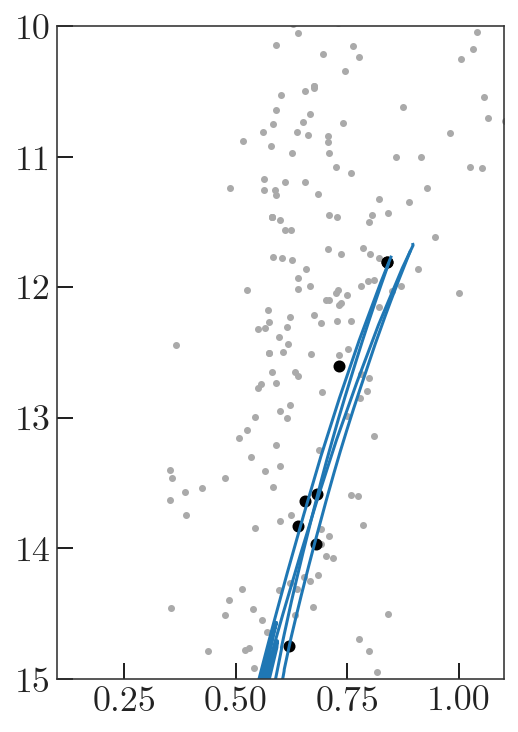

In [259]:
plt.figure(figsize=(4, 6))
plt.scatter((g.J - g.K)[phi_mask & pm_mask], g.H[phi_mask & pm_mask], 
            color='#aaaaaa', marker='.')

plt.scatter((g.J - g.K)[phi_mask & pm_mask & rv_mask & feh_mask], 
            g.H[phi_mask & pm_mask & rv_mask & feh_mask],
            color='k')

for iso in isos:
    for ph in np.unique(iso['phase']):
        i = iso[iso['phase'] == ph]
        plt.plot(i['2MASS_J']-i['2MASS_Ks'], i['2MASS_H']+DM, 
                 marker='', color='tab:blue')

plt.ylim(15, 10)
plt.xlim(0.1, 1.1)

---
# Check LAMOST

In [201]:
lamost_g = GaiaData('/Users/adrian/data/LAMOST/lamost-dr3-gaia-dr2.fits')

In [203]:
c = lamost_g.get_skycoord(distance=False,
                          radial_velocity=lamost_g.rv)

c = c.transform_to(gc.Orphan)

phi1 = c.phi1.wrap_at(180*u.deg)
phi2 = c.phi2

pm1 = c.pm_phi1_cosphi2.to(u.mas/u.yr)
pm2 = c.pm_phi2.to(u.mas/u.yr)

rv = c.radial_velocity
rv_err = lamost_g.rv_err

In [204]:
phi_mask = phi_path.contains_points(np.vstack((phi1, phi2)).T)
pm_mask = pm_path.contains_points(np.vstack((pm1, pm2)).T)

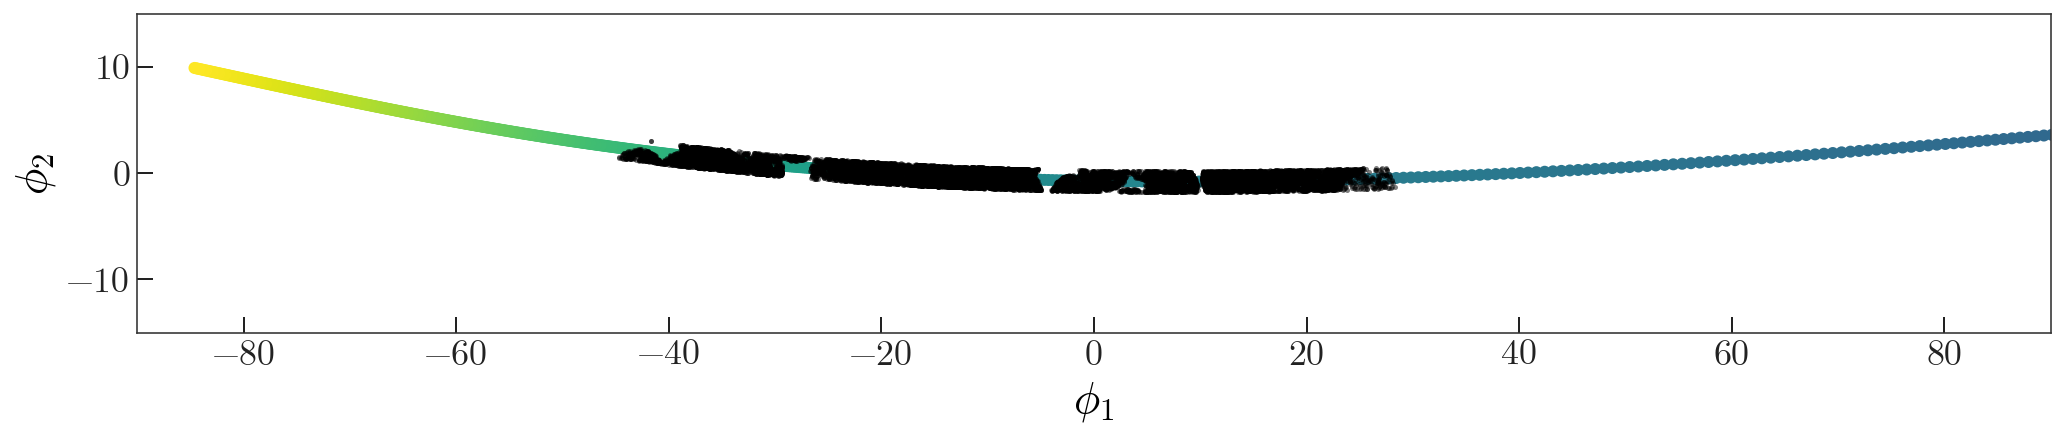

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(phi1[phi_mask], phi2[phi_mask], 
        marker='.', color='k', ls='none', alpha=0.5)

ax.scatter(orbit_c.phi1.wrap_at(180*u.deg).degree, 
           orbit_c.phi2.degree, c=orbit.t.value)

ax.set_xlim(-90, 90)
ax.set_ylim(-15, 15)
ax.set_aspect('equal')

ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')

fig.tight_layout()

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


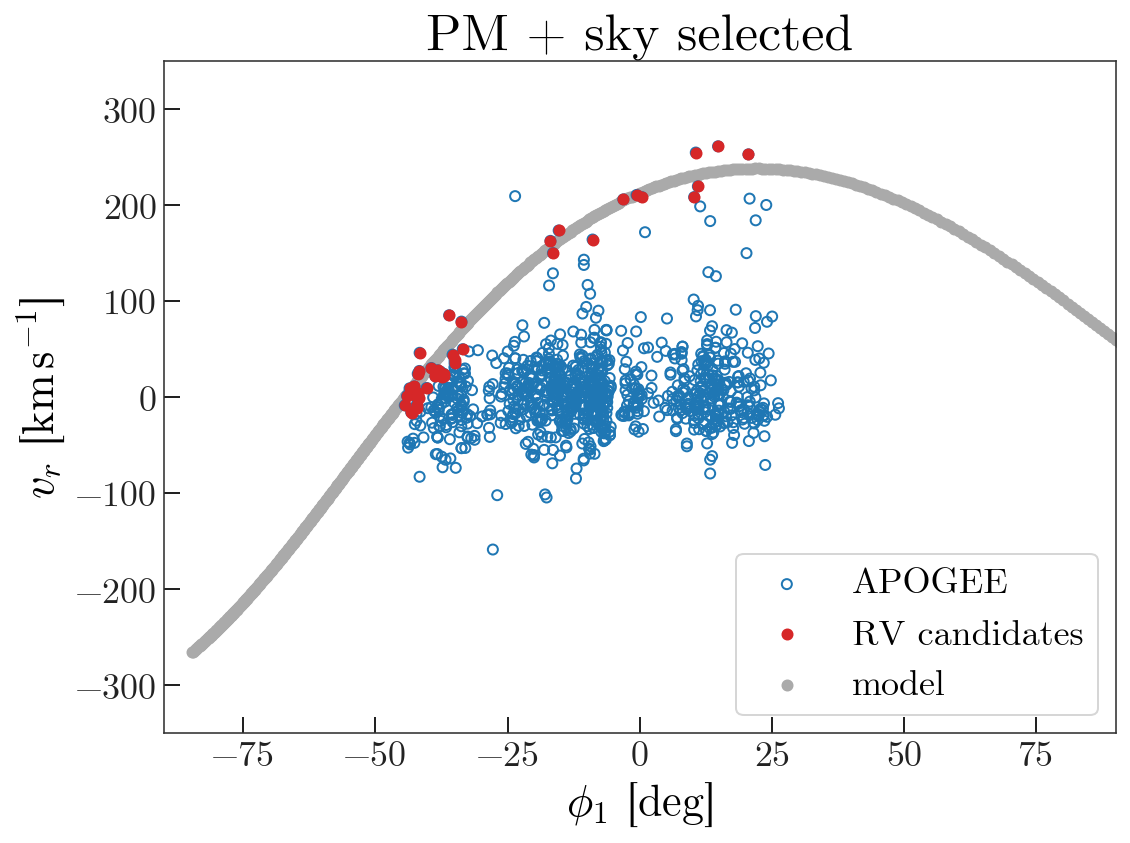

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

drv = np.abs(phi1_to_rv(phi1.value) - rv.value)
rv_mask = drv < 30.

ax.scatter(phi1[phi_mask & pm_mask], rv[phi_mask & pm_mask], 
           marker='o', color='tab:blue', linewidth=1, facecolor='none',
           alpha=1, s=25, label='APOGEE')

ax.scatter(phi1[phi_mask & pm_mask & rv_mask],
           rv[phi_mask & pm_mask & rv_mask], 
           color='tab:red', label='RV candidates')

ax.scatter(orbit_c.phi1.wrap_at(180*u.deg),
           orbit_c.radial_velocity.to(u.km/u.s), 
           zorder=-100, color='#aaaaaa',
           label='model')

ax.set_xlim(-90, 90)
ax.set_ylim(-350, 350)

ax.set_xlabel(r'$\phi_1$ [deg]')

ax.legend(loc='best', fontsize=18)
ax.set_ylabel(r'$v_r$ [{0:latex_inline}]'.format(u.km/u.s))
ax.set_title('PM + sky selected')
fig.tight_layout()

In [211]:
feh_mask = lamost_g.feh < -1.

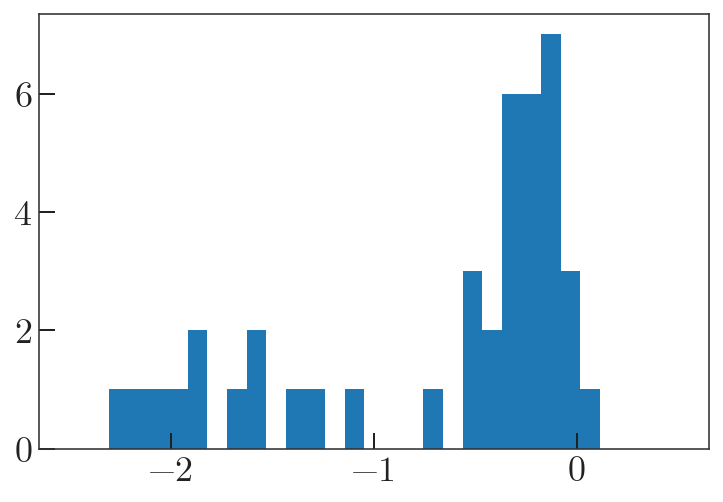

In [212]:
plt.hist(lamost_g.feh[phi_mask & pm_mask & rv_mask], 
         bins=np.linspace(-2.5, 0.5, 32));

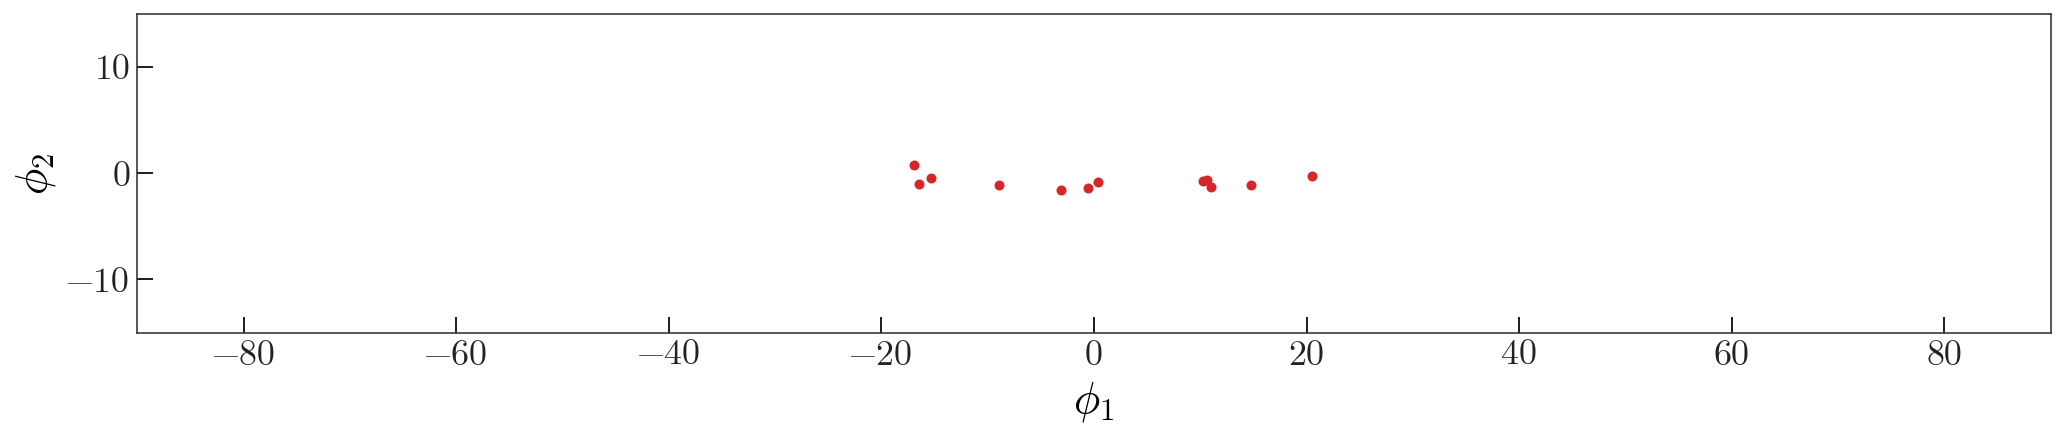

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(phi1[phi_mask & pm_mask & rv_mask & feh_mask], 
        phi2[phi_mask & pm_mask & rv_mask & feh_mask], 
        marker='o', color='tab:red', ls='none', alpha=1)

# ax.set_xlim(-100, 20)
# ax.set_ylim(-10, 5)

ax.set_xlim(-90, 90)
ax.set_ylim(-15, 15)

ax.set_aspect('equal')

ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')

fig.tight_layout()